## Example image load

In [1]:
import PIL
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torchmetrics

import numpy as np 
import pandas as pd 
import os




## Movenet model download

In [2]:
import sys,os

#for linux users
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
#for windows users
!powershell Invoke-WebRequest -Uri https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite -OutFile movenet_thunder.tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

'wget' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'examples' already exists and is not an empty directory.


## Movenet inference definition

In [3]:
# Download model from TF Hub and check out inference code from GitHub


from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=1):
    """Runs detection on an input image.

      Args:
        input_tensor: A [height, width, 3] Tensor of type tf.float32.
          Note that height and width can be anything since the image will be
          immediately resized according to the needs of the model within this
          function.
        inference_count: Number of times the model should run repeatly on the
          same input image to improve detection accuracy.

      Returns:
        A Person entity detected by the MoveNet.SinglePose.
    """
    image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)

    # Repeatedly using previous detection result to identify the region of
    # interest and only croping that region to improve detection accuracy
    for _ in range(inference_count):
        person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)
    return person

In [4]:
def draw_prediction_on_image(
    image, person, crop_region = None, close_figure = True,
    keep_input_size = False):
    """Draws the keypoint predictions on image.

      Args:
        image: An numpy array with shape [height, width, channel] representing the
          pixel values of the input image.
        person: A person entity returned from the MoveNet.SinglePose model.
        close_figure: Whether to close the plt figure after the function returns.
        keep_input_size: Whether to keep the size of the input image.

      Returns:
        An numpy array with shape [out_height, out_width, channel] representing the
        image overlaid with keypoint predictions.
    """
    # Draw the detection result on top of the image.
    image_np = utils.visualize(image, [person])
    # Plot the image with detection results.
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    im = ax.imshow(image_np)
    if close_figure:
        plt.close(fig)
    if not keep_input_size:
        image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))
    return image_np

## Keypoint extraction

In [5]:
# remove these images
from glob import glob
import shutil

def filter_out_images(classes = ["Virabhadrasana One", 
                                 "Virabhadrasana Two", 
                                 "Adho Mukha Svanasana", 
                                 "Balasana",
                                 "Vrksasana","Vrksasana One", "Vrksasana Two"],
                                 to_delete = {},
                                 to_seperate = {}):
    #Delete folders not named in classes
    #check if its a folder
    for folder in os.listdir(os.path.join(".","online_data")):
        full_name = os.path.join(".","online_data", folder)
        if folder not in classes and os.path.isdir(full_name):
            shutil.rmtree(os.path.join(".","online_data", folder))
    
    #Delete images in to_delete
    for folder in to_delete:
        for file in to_delete[folder]:
            #find file extension using glob
            
            file_list = glob(os.path.join(".","online_data", folder, file + ".*"))
            if len(file_list) == 0:
                continue
            file = file_list[0]
            os.remove(file)
    
    #seperate images from not numbered name to numbered names in to_seperate
    remove_root = ""
    for folder in to_seperate:
        for file in to_seperate[folder]:
            dirname = os.path.join(".","online_data", folder)
            #check if dir exists
            if not os.path.isdir(dirname):
                os.mkdir(dirname)
            file_list = glob(os.path.join(".","online_data", folder.split(" ")[0], file + ".*"))
            if len(file_list) == 0:
                continue
            file = file_list[0]
            shutil.move(file, os.path.join(".","online_data", folder))
    remove_root = os.path.join(".","online_data", folder.split(" ")[0])
    if os.path.isdir(remove_root):
        shutil.rmtree(remove_root)
    return
def transfer_imgs_to_folder(file_path = os.path.join(".","our_data")):

    for folder in os.listdir(file_path):
        if os.path.isdir(os.path.join(file_path, folder)):
            for file in os.listdir(os.path.join(file_path, folder)):
                
                shutil.move(os.path.join(file_path, folder, file), os.path.join(".","online_data", folder ,file))

    return

#Loads the image from the directories and subdirectories
#Flips the images
#Saves the images to the same directory
def create_augmented_images(dir_path):
    for folder in os.listdir(dir_path):
        if os.path.isdir(os.path.join(dir_path, folder)):
            for file in os.listdir(os.path.join(dir_path, folder)):
                img = PIL.Image.open(os.path.join(dir_path, folder, file))
                img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                #check if file exists
                if os.path.isfile(os.path.join(dir_path, folder, "flip_" + file)):
                    continue
                if img.mode == 'RGBA':
                    img = img.convert('RGB')
                img.save(os.path.join(dir_path, folder, "flip_" + file))
                
        
    
    return

    

    




    
to_delete = {
    "Virabhadrasana One" : ['File13', 'File49', 'File7', 'File12', 'File47', 'File26', 'File8', 'File32', 'File43', 'File62'],
    "Virabhadrasana Two" : ['File57', 'File44', 'File35', 'File27'],
    "Adho Mukha Svanasana" : ['File34', 'File43', 'File3', 'File11', 'File18', 'File20', 'File47', 'File58'],
    "Balasana" : ['File26', 'File27', 'File12', 'File16', 'File35', 'File39', 'File68', 'File69', 'File36', 'File29', 'File32'],
    "Vrksasana One":[],
    "Vrksasana Two":[]
}

to_seperate = {
 "Vrksasana One" : ['File1', 'File3', 'File4', 'File5', 'File6', 'File9', 'File11', 'File12', 'File14', 'File15', 'File20', 'File21', 'File23', 'File24', 'File28', 'File29', 'File36', 'File45', 'File52', 'File53', 'File54', 'File56', 'File57', 'File60', 'File65'],
 "Vrksasana Two" : ['File2', 'File7', 'File8', 'File10', 'File16', 'File17', 'File19', 'File22', 'File27', 'File31', 'File32', 'File33', 'File34', 'File35', 'File38', 'File39', 'File41', 'File44', 'File46', 'File47', 'File48', 'File49', 'File50', 'File51', 'File55', 'File58', 'File59', 'File61', 'File62', 'File63', 'File64', 'File66', 'File67', 'File68']
}

filter_out_images(to_delete = to_delete, to_seperate = to_seperate)
transfer_imgs_to_folder()
create_augmented_images(os.path.join(".","online_data"))


In [6]:
import tempfile
import csv
from tqdm import tqdm
import utils
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from data import BodyPart

class MoveNetPreprocessor(object):
    """Helper class to preprocess pose sample images for classification."""
    
    def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
        """Creates a preprocessor to detection pose from images and save as CSV.
        Args:
          images_in_folder: Path to the folder with the input images. It should
            follow this structure:
            yoga_poses
            |__ downdog
                |______ 00000128.jpg
                |______ 00000181.bmp
                |______ ...
            |__ goddess
                |______ 00000243.jpg
                |______ 00000306.jpg
                |______ ...
            ...
          images_out_folder: Path to write the images overlay with detected
            landmarks. These images are useful when you need to debug accuracy
            issues.
          csvs_out_path: Path to write the CSV containing the detected landmark
            coordinates and label of each image that can be used to train a pose
            classification model.
        """
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._messages = []
        # Create a temp dir to store the pose CSVs per class
        self._csvs_out_folder_per_class = tempfile.mkdtemp()
        # Get list of pose classes and print image statistics
        self._pose_class_names = sorted([n for n in 
                                         os.listdir(self._images_in_folder)
                                         if not n.startswith('.') and not '.' in n])
        
    def process(self, per_pose_class_limit=None, detection_threshold=0.1):
        """Preprocesses images in the given folder.
            Args:
            per_pose_class_limit: Number of images to load. As preprocessing usually
            takes time, this parameter can be specified to make the reduce of the
            dataset for testing.
              detection_threshold: Only keep images with all landmark confidence score
                above this threshold.
        """
        # Loop through the classes and preprocess its images
        for pose_class_name in self._pose_class_names:
            print('Preprocessing', pose_class_name, file=sys.stderr)
            # Paths for the pose class
            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                      pose_class_name + '.csv')
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)
            # Detect landmarks in each image and write it to a CSV file
            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, 
                                        delimiter=',', 
                                        quoting=csv.QUOTE_MINIMAL)
                # Get list of images
                image_names = sorted(
                    [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
                if per_pose_class_limit is not None:
                    image_names = image_names[:per_pose_class_limit]
                valid_image_count = 0
                # Detect pose landmarks from each image
                for image_name in tqdm(image_names):
                    image_path = os.path.join(images_in_folder, image_name)
                    try:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                    except:
                        self._messages.append('Skipped ' + image_path + '. Invalid image.')
                        continue
                    else:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                        image_height, image_width, channel = image.shape
                        if channel == 4:
                            image = tf.slice(image, [0, 0, 0], [-1, -1, 3]);
                            channel = 3
                    # Skip images that isn't RGB because Movenet requires RGB images

                        
                    if channel != 3:
                        self._messages.append('Skipped ' + image_path +
                                      '. Image isn\'t in RGB format.')
                        continue
                    person = detect(image)
                # Save landmarks if all landmarks were detected
                    min_landmark_score = min(
                        [keypoint.score for keypoint in person.keypoints])
                    should_keep_image = min_landmark_score >= detection_threshold
                    if not should_keep_image:
                        self._messages.append('Skipped ' + image_path +
                                      '. No pose was confidentlly detected.')
                        continue
                    valid_image_count += 1
                    # Draw the prediction result on top of the image for debugging later
                    output_overlay = draw_prediction_on_image(
                        image.numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)

                      # Write detection result into an image file
                    output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
                    # Get landmarks and scale it to the same size as the input image
                    pose_landmarks = np.array(
                          [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                            for keypoint in person.keypoints],
                          dtype=np.float32)
                    # Write the landmark coordinates to its per-class CSV file
                    coordinates = pose_landmarks.flatten().astype(np.str_).tolist()
                    csv_out_writer.writerow([image_name] + coordinates)
                if not valid_image_count:
                    raise RuntimeError(
                        'No valid images found for the "{}" class.'
                        .format(pose_class_name))

        # Print the error message collected during preprocessing.
        print('\n'.join(self._messages))

        # Combine all per-class CSVs into a single output file
        all_landmarks_df = self._all_landmarks_as_dataframe()
        all_landmarks_df.to_csv(self._csvs_out_path, index=False)
        
    def class_names(self):
        """List of classes found in the training dataset."""
        return self._pose_class_names
    def _all_landmarks_as_dataframe(self):
        """Merge all per-class CSVs into a single dataframe."""
        total_df = None
        for class_index, class_name in enumerate(self._pose_class_names):
            csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                      class_name + '.csv')
            per_class_df = pd.read_csv(csv_out_path, header=None)
            # Add the labels
            per_class_df['class_no'] = [class_index]*len(per_class_df)
            per_class_df['class_name'] = [class_name]*len(per_class_df)
            # Append the folder name to the filename column (first column)
            per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
            + per_class_df[per_class_df.columns[0]].astype(str))
            if total_df is None:
                # For the first class, assign its data to the total dataframe
                total_df = per_class_df
            else:
                # Concatenate each class's data into the total dataframe
                total_df = pd.concat([total_df, per_class_df], axis=0)

        list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                      bodypart.name + '_score'] for bodypart in BodyPart] 
        header_name = []
        for columns_name in list_name:
            header_name += columns_name
        header_name = ['file_name'] + header_name
        header_map = {total_df.columns[i]: header_name[i] 
                      for i in range(len(header_name))}

        total_df.rename(header_map, axis=1, inplace=True)

        return total_df
    
preproc = MoveNetPreprocessor(images_in_folder = "online_data", 
                              images_out_folder = "landmarked_images", 
                              csvs_out_path="pp_data.csv",
                              )
preproc.process()

Preprocessing Adho Mukha Svanasana
100%|██████████| 222/222 [00:32<00:00,  6.87it/s]
Preprocessing Balasana
  4%|▍         | 8/192 [00:00<00:16, 11.31it/s]c:\FER\erasmus\ITU\duboko\project\project\.venv\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\FER\erasmus\ITU\duboko\project\project\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 192/192 [00:33<00:00,  5.80it/s]
Preprocessing Virabhadrasana One
100%|██████████| 168/168 [00:27<00:00,  6.01it/s]
Preprocessing Virabhadrasana Two
100%|██████████| 206/206 [00:36<00:00,  5.59it/s]
Preprocessing Vrksasana One
100%|██████████| 104/104 [00:26<00:00,  3.90it/s]
Preprocessing Vrksasana Two
100%|██████████| 116/116 [00:27<00:00,  4.15it/s]

Skipped online_data\Adho Mukha Svanasana\File45.png. Image isn't in RGB format.
Skipped online_data\Adho Mukha Svanasana\Screenshot (13).png. No pose was confidentlly detected.
Skipped online_data\Adho Mukha Svanasana\flip_File45.png. Image isn't in RGB format.
Skipped online_data\Adho Mukha Svanasana\flip_Screenshot (64).png. No pose was confidentlly detected.
Skipped online_data\Balasana\File19.png. No pose was confidentlly detected.
Skipped online_data\Balasana\File45.jpg. No pose was confidentlly detected.
Skipped online_data\Balasana\File57.png. No pose was confidentlly detected.
Skipped online_data\Balasana\File60.png. No pose was confidentlly detected.
Skipped online_data\Balasana\File67.png. No pose was confidentlly detected.
Skipped online_data\Balasana\File71.png. No pose was confidentlly detected.
Skipped online_data\Balasana\File74.jpeg. No pose was confidentlly detected.
Skipped online_data\Balasana\Screenshot17.png. No pose was confidentlly detected.
Skipped online_data\B

In [7]:
df = pd.read_csv("pp_data.csv")
df

,file_name,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,...,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score,class_no,class_name
0,Adho Mukha Svanasana\File1.png,328.0,245.0,0.768427,315.0,250.0,0.669465,315.0,250.0,0.775290,...,194.0,0.911892,619.0,314.0,0.819782,612.0,301.0,0.861895,0,Adho Mukha Svanasana
1,Adho Mukha Svanasana\File10.png,258.0,206.0,0.667730,269.0,212.0,0.482987,271.0,213.0,0.615946,...,180.0,0.818027,63.0,279.0,0.883879,42.0,303.0,0.702556,0,Adho Mukha Svanasana
2,Adho Mukha Svanasana\File12.png,184.0,196.0,0.352434,191.0,203.0,0.478106,187.0,202.0,0.545828,...,144.0,0.790052,73.0,202.0,0.653024,26.0,209.0,0.827190,0,Adho Mukha Svanasana
3,Adho Mukha Svanasana\File13.png,540.0,300.0,0.465930,555.0,305.0,0.408687,554.0,305.0,0.399856,...,219.0,0.782110,250.0,336.0,0.765704,237.0,339.0,0.698020,0,Adho Mukha Svanasana
4,Adho Mukha Svanasana\File14.png,426.0,282.0,0.572158,443.0,289.0,0.769721,443.0,289.0,0.725529,...,221.0,0.734958,108.0,310.0,0.858711,29.0,354.0,0.878436,0,Adho Mukha Svanasana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,Vrksasana Two\flip_Screenshot91.png,1545.0,582.0,0.745491,1563.0,558.0,0.837128,1516.0,558.0,0.799616,...,1315.0,0.894338,1576.0,1170.0,0.702239,1566.0,1552.0,0.924329,5,Vrksasana Two
963,Vrksasana Two\flip_Screenshot92.png,1975.0,487.0,0.668169,1999.0,458.0,0.758076,1944.0,461.0,0.684750,...,1085.0,0.873639,1901.0,1503.0,0.784743,1864.0,1148.0,0.808159,5,Vrksasana Two
964,Vrksasana Two\flip_Screenshot93.png,2257.0,565.0,0.577477,2275.0,551.0,0.637783,2239.0,549.0,0.542171,...,1238.0,0.945965,2255.0,1154.0,0.383039,2206.0,1470.0,0.783644,5,Vrksasana Two
965,Vrksasana Two\flip_Screenshot95.png,608.0,541.0,0.611752,587.0,512.0,0.676260,633.0,512.0,0.679484,...,1145.0,0.732478,657.0,1595.0,0.860645,685.0,1149.0,0.643466,5,Vrksasana Two


In [8]:
for col in df.columns:
    print(col)

file_name
NOSE_x
NOSE_y
NOSE_score
LEFT_EYE_x
LEFT_EYE_y
LEFT_EYE_score
RIGHT_EYE_x
RIGHT_EYE_y
RIGHT_EYE_score
LEFT_EAR_x
LEFT_EAR_y
LEFT_EAR_score
RIGHT_EAR_x
RIGHT_EAR_y
RIGHT_EAR_score
LEFT_SHOULDER_x
LEFT_SHOULDER_y
LEFT_SHOULDER_score
RIGHT_SHOULDER_x
RIGHT_SHOULDER_y
RIGHT_SHOULDER_score
LEFT_ELBOW_x
LEFT_ELBOW_y
LEFT_ELBOW_score
RIGHT_ELBOW_x
RIGHT_ELBOW_y
RIGHT_ELBOW_score
LEFT_WRIST_x
LEFT_WRIST_y
LEFT_WRIST_score
RIGHT_WRIST_x
RIGHT_WRIST_y
RIGHT_WRIST_score
LEFT_HIP_x
LEFT_HIP_y
LEFT_HIP_score
RIGHT_HIP_x
RIGHT_HIP_y
RIGHT_HIP_score
LEFT_KNEE_x
LEFT_KNEE_y
LEFT_KNEE_score
RIGHT_KNEE_x
RIGHT_KNEE_y
RIGHT_KNEE_score
LEFT_ANKLE_x
LEFT_ANKLE_y
LEFT_ANKLE_score
RIGHT_ANKLE_x
RIGHT_ANKLE_y
RIGHT_ANKLE_score
class_no
class_name


## Keypoint dataset creation

In [9]:
import torch
class YogaDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):

        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)
    
    def  __getitem__(self, index):
        X = self.data[index]
        y = self.labels[index]
        return X, y

## Representative data extraction

Calculates average angle for each pose between nose keypoint and each other keypoint.

In [10]:
import math

def create_angle_rep_for_each_class(df):
    #create output dataframe
    df2 = pd.DataFrame()
    #iterate through columns
    for col_name in df.columns:
        #take the x column first
        if col_name.endswith("x"):
            #calculate the difference between x coordinates
            dx = df[col_name] - df["NOSE_x"]
            #repeat for y coordinates
            dy = df[col_name[:-1]+"y"] - df["NOSE_y"]
            #calculate angle from differences
            col_basename = col_name[:-1]

            df2[col_basename+"angle"] = np.arctan2(dy, dx)

    #copy class names and numbers        
    df2["class_name"] = df["class_name"]
    df2["class_no"] = df["class_no"]
    #use the mean angle for each class
    df2 = df2.groupby(["class_no","class_name"]).mean()
    return df2

correction_inference_df = create_angle_rep_for_each_class(df)
correction_inference_df.to_csv("correction_angles.csv")
correction_inference_df

,,NOSE_angle,LEFT_EYE_angle,RIGHT_EYE_angle,LEFT_EAR_angle,RIGHT_EAR_angle,LEFT_SHOULDER_angle,RIGHT_SHOULDER_angle,LEFT_ELBOW_angle,RIGHT_ELBOW_angle,LEFT_WRIST_angle,RIGHT_WRIST_angle,LEFT_HIP_angle,RIGHT_HIP_angle,LEFT_KNEE_angle,RIGHT_KNEE_angle,LEFT_ANKLE_angle,RIGHT_ANKLE_angle
class_no,class_name,,,,,,,,,,,,,,,,,
0,Adho Mukha Svanasana,0.0,0.837065,0.587946,-1.417525,-1.551662,-1.515283,-1.603693,1.279614,0.926945,1.474463,1.632099,-1.563504,-1.589491,-1.567234,-1.594627,1.432973,1.507318
1,Balasana,0.0,-0.736223,-1.025718,-1.478777,-1.597325,-1.411797,-1.699678,0.153506,-0.948047,1.029235,-0.211153,-1.508020,-1.571102,-0.799041,0.067748,-0.878500,0.253160
2,Virabhadrasana One,0.0,-0.926133,-0.878694,0.414166,0.463040,1.460707,1.676897,-1.445429,-1.575974,-1.527766,-1.563312,1.518100,1.622513,1.275675,1.871714,1.257699,1.884803
3,Virabhadrasana Two,0.0,-1.367745,-1.777108,-1.067021,-1.037030,1.003601,2.143052,0.571607,2.571758,0.433930,2.705315,1.444524,1.696928,1.190510,1.949982,1.193785,1.948755
4,Vrksasana One,0.0,-0.715701,-2.421712,-0.033586,0.415617,0.859442,2.275434,1.056594,2.086068,1.426888,1.706995,1.425377,1.719644,1.344080,1.794506,1.548734,1.594154
5,Vrksasana Two,0.0,-0.838450,-2.325673,-0.224574,0.575107,0.922813,2.230102,-0.880692,-2.286975,-1.412897,-1.725203,1.445803,1.702383,1.370872,1.771066,1.548434,1.598299


In [11]:
from torch.utils.data import random_split

def prepare_df(df):
    df2 = df.drop(["file_name","class_name"], axis = 1)
    return df2

df2 = prepare_df(df)
s1 = set(df2.columns)
s2 = set(["class_no"])
kps_names = list(s1-s2)

X = df2[kps_names]
y = df2["class_no"]
yoga_ds = YogaDataset(X, y)

print(len(yoga_ds))
num_of_kps = len(kps_names)
num_of_poses = df2["class_no"].max() + 1




967


## EDA

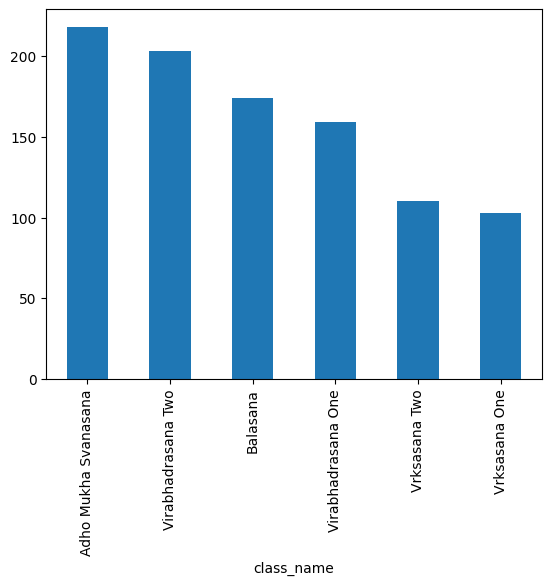

In [12]:
df["class_name"].value_counts().plot.bar()
plt.show()

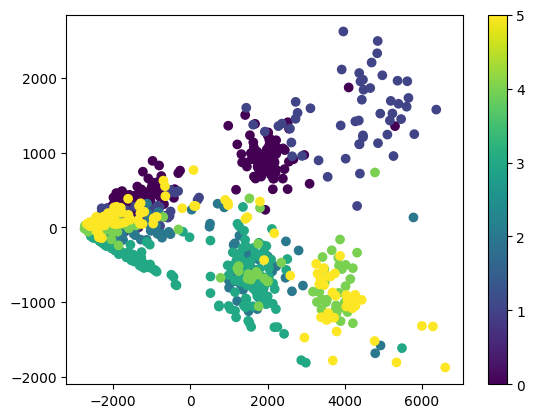

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Change n_components to the number of principal components you want

# Fit and transform the data
df_pca = pca.fit_transform(X)

# df_pca is now a 2D numpy array containing the principal components. 
# You can convert it back to a DataFrame if necessary:
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

plt.scatter(df_pca["PC1"], df_pca["PC2"], c = y, cmap='viridis')
plt.colorbar() 
plt.show()


## Data split

Creates data loaders and splits the dataset into train, test and validation.

In [14]:
def create_dataloader(dataset, batch_size):
    #TODO: set seed
    test_length = int(len(dataset) * 0.2)
    val_length = int(len(dataset) * 0.2)
    train_length = len(dataset) - (test_length + val_length)

    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_length, val_length, test_length])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Keypoint classifier definition

Define model architecture for classifing keypoints into yoga poses.

In [15]:
class YogaModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    


Setup cross entropy loss, optimizer and metrics.

## Training hyperparameter setup

In [16]:
num_of_poses = int(num_of_poses)
NUM_CLASSES = num_of_poses

def setup(model, lr, optimizer_params):
    #Define cross entropy loss as optimizer
    criterion = nn.CrossEntropyLoss()
    #Define optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr = optimizer_params["lr"],
                                weight_decay = optimizer_params["wd"],
                                amsgrad = optimizer_params["ag"])
    
    #Store metrics calculation functions into the dictionary
    metrics = {
        'accuracy':torchmetrics.Accuracy(task = "multiclass",num_classes = NUM_CLASSES),
        'precision':torchmetrics.Precision(task = "multiclass",average='macro', num_classes = NUM_CLASSES),
        'recall':torchmetrics.Recall(task = "multiclass",average='macro', num_classes = NUM_CLASSES),
        'f1':torchmetrics.F1Score(task = "multiclass",average='macro', num_classes = NUM_CLASSES)
    }

    return criterion, optimizer, metrics

## Training

Define the training loop
We will follow the f1 metric to determine during which epoch the model performed the bed
F1 metric combines recall and precision so it's usually the most informative metric to 
measure model performance

In [17]:
import copy

def train(model, train_loader, val_loader, criterion, optimizer, metrics, device, num_epochs = 10):
    

    best_f1_score = 0
    best_model = None
    
    metric_results = {name:[] for name in metrics}
    metric_results["loss"] = []
    #loop over epochs    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        #Training
        #Set model into training mode
        model.train()
        #Reset all the metrics becuase new epoch is starting
        for metric in metrics.values():
            metric.reset()
            
        #Iterate through the train dataset
        for inputs, labels in tqdm(train_loader):
            #Put data on the device that is currently in the use
            inputs = inputs.to(device)
            labels = labels.to(device)
            #Erase the leftover garbage in optimizers memory
            optimizer.zero_grad()
            #Create model prediction
            outputs = model(inputs)
            #Calculate loss
            loss = criterion(outputs, labels.long())
            #Perform backpropagation
            loss.backward()
            #Update weights
            optimizer.step()
            #Update each metric with new values caluclated for current batch
            for metric in metrics.values():
                metric.update(outputs.detach(), labels.detach())
        #print("Train metrics:")
        #for name, metric in metrics.items():
        #    print(f'\t{name}: {metric.compute()}')
        #Set the model in evaulation mode
        model.eval()
        #Call no grad to inform pytorch to not store layer results
        #for easier backpropagation calculation
        with torch.no_grad():
            #Reset metrics
            for metric in metrics.values():
                metric.reset()
            for inputs, labels in tqdm(val_loader):
                #Turn to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                #Calculate outputs
                outputs = model(inputs)
                #Calculate loss
                loss = criterion(outputs, labels.long())
                #Calculate metrics
                for metric in metrics.values():
                    metric.update(outputs.detach(), labels.detach())
        #print("Validation metrics:")
        for name, metric in metrics.items():
            metric_results[name].append(metric.compute())
        metric_results["loss"].append(loss.detach())
            #print(f'\t{name}: {metric.compute()}')
        #Check if the current model is the best performing one
        if best_model is None or best_f1_score < metrics["f1"]:
            best_f1_score = metrics["f1"]
            best_model = copy.deepcopy(model)
    print("Training complete")
    return best_model, metric_results 

Define hyperparameter values that will be tested

In [41]:

learning_rates = [0.001, 0.5, 0.1,0.05, 0.01, 0.005, 0.0005, 0.0001]

weight_decays = [0.0001,0.001,0.01 ,0.1]

amsgrad_vals = [False,True]


Here is defined one whole training process for a given model.
From building the dataloaders to training loop, the idea is to make it modular for easier hyperparameter optimizing.

In [42]:

%%capture
def whole_training(yoga_ds, batch_size, model, num_epochs, optimizer_params):
    #Here is defined one whole training process for given model
    #perform dataloader creation e.g. data split
    train_loader,val_loader,test_loader = create_dataloader(yoga_ds, batch_size)
    #create model metrics, optimizer and criterion
    criterion, optimizer, metrics = setup(model, lr, optimizer_params)
    #Check which device is in use
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #Load the model on the device thats in use
    model = model.to(device)
    #Perform the training
    model, metric_val_results = train(model, 
              train_loader,
              val_loader,
              criterion,
              optimizer,
              metrics,
              device,
              num_epochs = num_epochs)
    return model, metric_val_results

num_epochs = 30
batch_size = 32
best_model = None
best_lr = 0
best_wd = 0
best_ag = None
best_f1 = 0

#Create dictionary for storing metrics for each hyperparameter
#combination
#(learning_rate,weight_decay, amsgrad_value):{f1:[],precision:[],recall:[],accuracy:[]}
#loss
all_metrics = {}
for lr in learning_rates:
    for wd in weight_decays:
        for ag in amsgrad_vals:
            model = YogaModel(num_of_kps, num_of_poses)

            optimizer_params = {"lr":lr,
                               "wd":wd,
                               "ag":ag}
            model, metric_val_results = whole_training(yoga_ds, 
                                                       batch_size, 
                                                       model, 
                                                       num_epochs, 
                                                       optimizer_params)
            current_f1 = max(metric_val_results["f1"])
            if current_f1 > best_f1:
                best_model = model
                best_f1 = current_f1
                best_lr = lr
                best_wd = wd
                best_ag = ag
            all_metrics[(lr,wd,ag)] = metric_val_results


In [44]:
print(best_lr)
print(best_wd)
print(best_ag)

0.001
0.001
False


## Results visualization

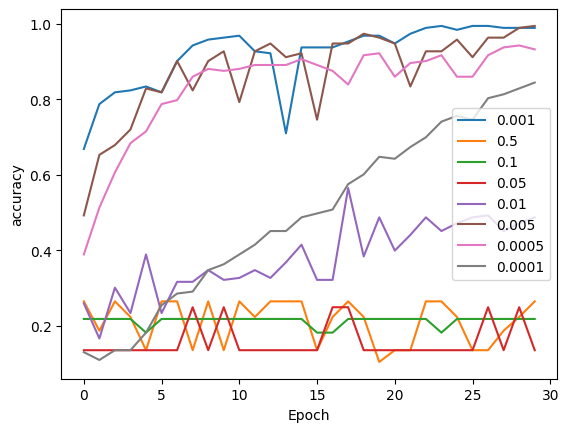

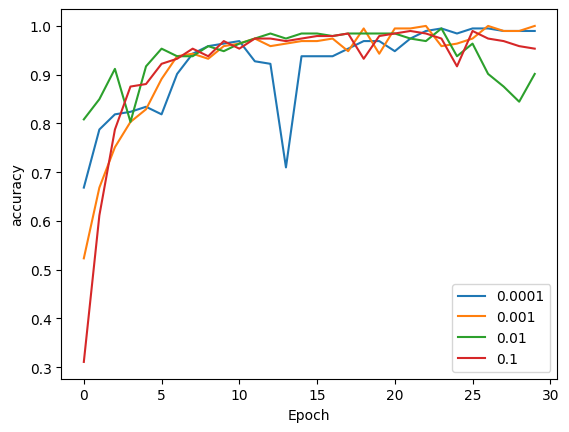

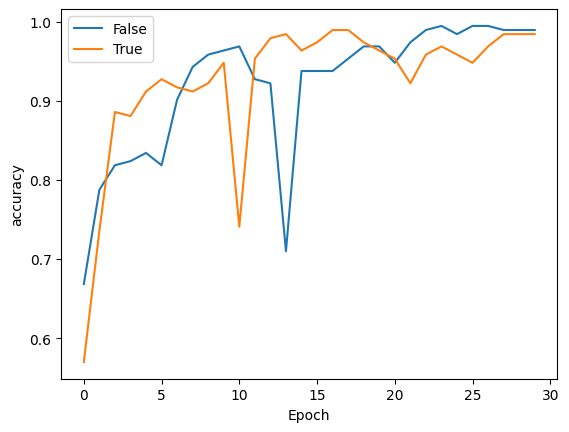

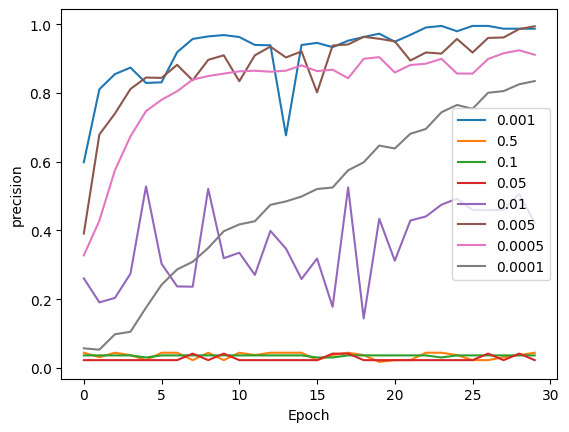

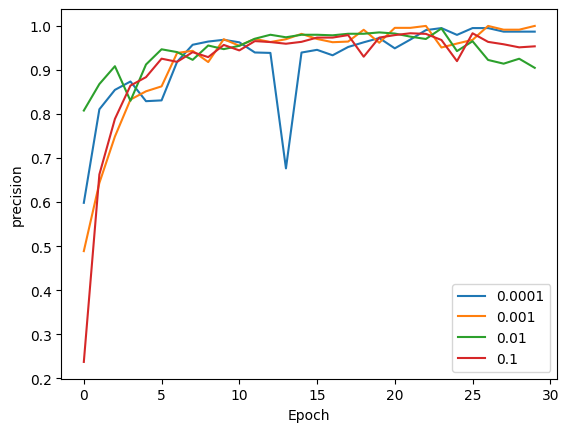

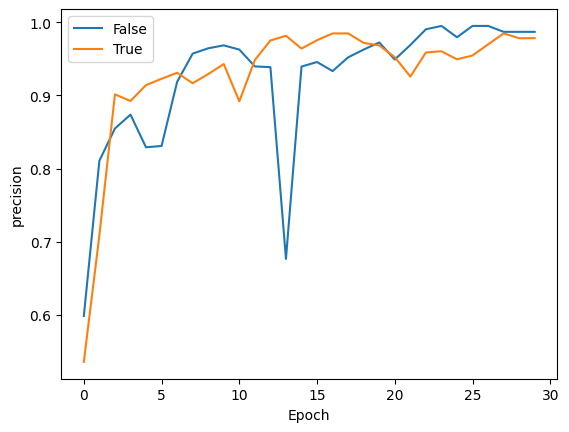

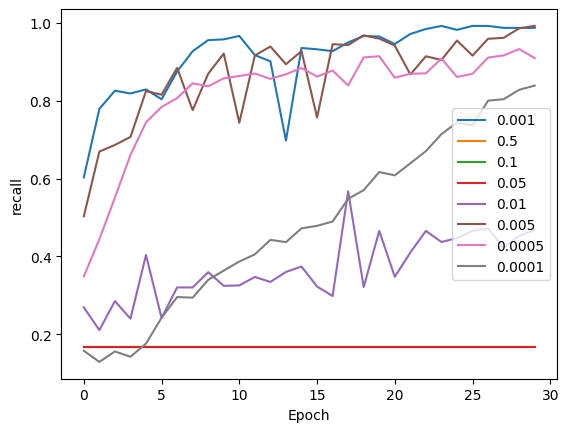

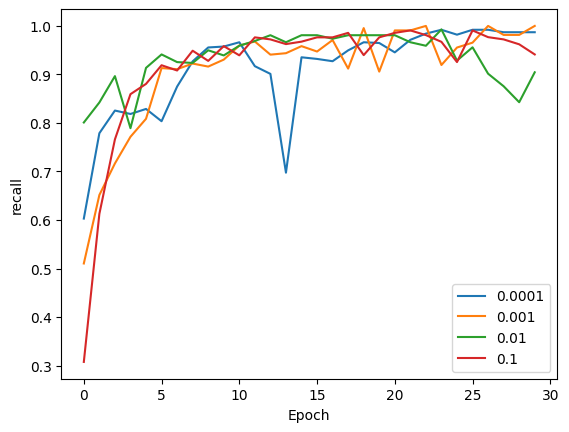

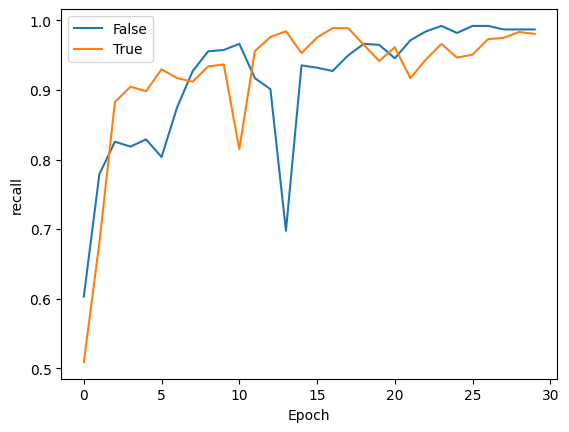

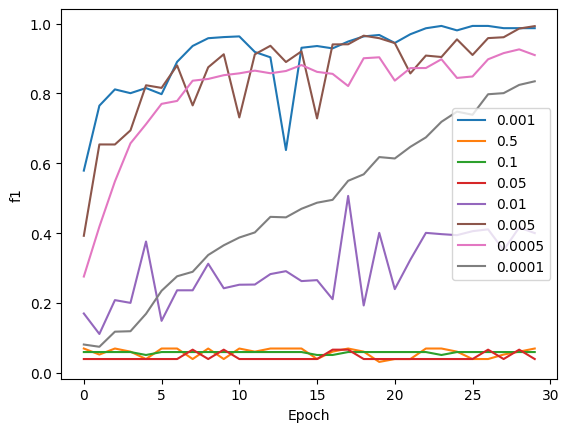

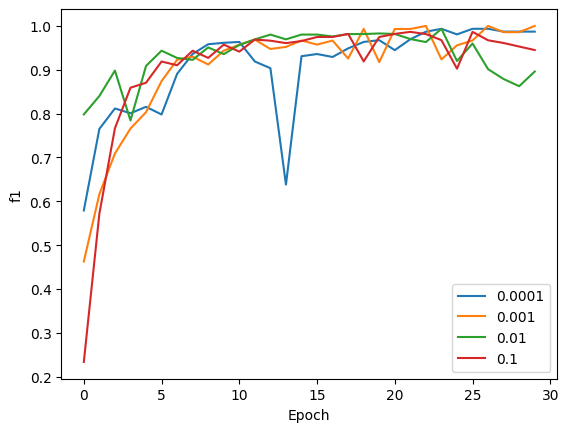

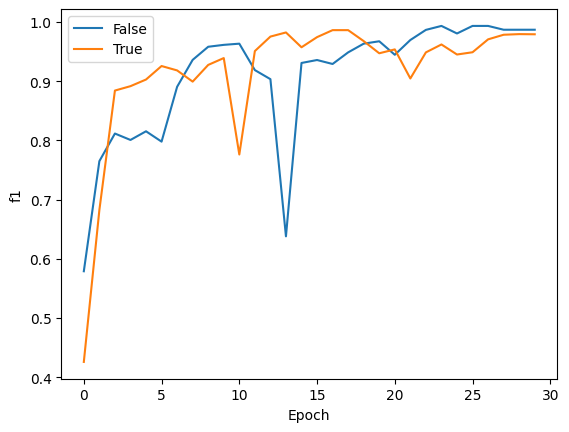

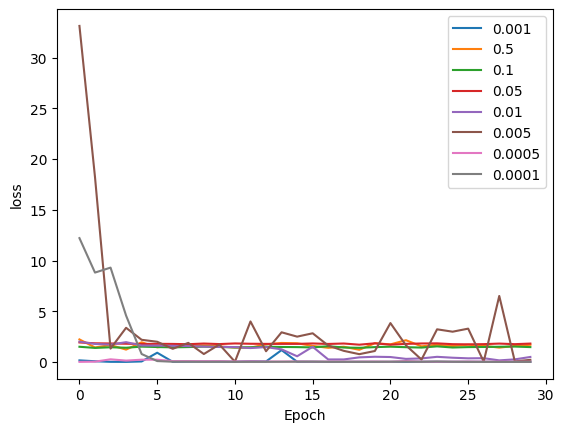

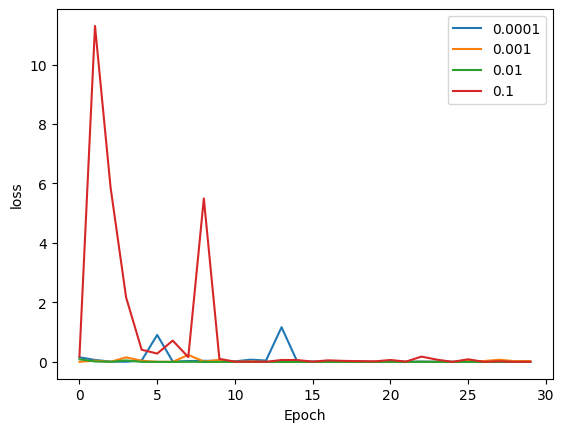

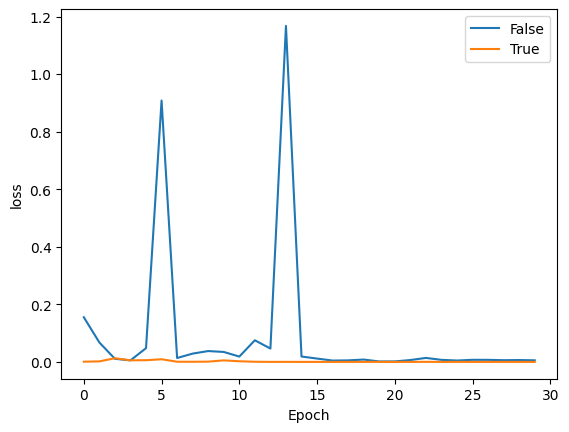

In [45]:



fixed_lr = learning_rates[0]
fixed_wd = weight_decays[0]
fixed_ag = amsgrad_vals[0]

metric_labels = [key for key in all_metrics[(fixed_lr,fixed_wd,fixed_ag)]]


for label in metric_labels:
    plt.figure()
    for key, value in all_metrics.items():
        if fixed_wd == key[1] and fixed_ag == key[2]:
            plt.plot(value[label], label = key[0])
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.show()

    plt.figure()
    for key, value in all_metrics.items():
        if fixed_lr == key[0] and fixed_ag == key[2]:
            plt.plot(value[label], label = key[1])
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.show()

    plt.figure()
    for key, value in all_metrics.items():
        if fixed_lr == key[0] and fixed_wd == key[1]:
            plt.plot(value[label], label = key[2])
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.show()



        
    

In [30]:

def test_model(model, metrics, test_loader, device):
    model.eval()
    #Call no grad to inform pytorch to not store layer results
    #for easier backpropagation calculation
    predictions = []
    with torch.no_grad():
        #Reset metrics
        for metric in metrics.values():
            metric.reset()
        for inputs, labels in tqdm(test_loader):
            #Turn to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            #Calculate outputs
            outputs = model(inputs)
            _, predicted = torch.max(outputs,1)
            predictions.extend(predicted)
            #Calculate loss
            loss = criterion(outputs, labels.long())
            #Calculate metrics
            for metric in metrics.values():
                metric.update(outputs.detach(), labels.detach())
    #print("Test metrics:")
    metric_results = {name:0 for name in metrics}
    for name, metric in metrics.items():
        metric_results[name] = metric.compute()
        
    return metric_results, predictions

In [31]:
a, b, test_loader = create_dataloader(yoga_ds, batch_size)
criterion, b, metrics = setup(model, lr, optimizer_params)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
metric_results, predictions = test_model(best_model, metrics, test_loader, device)

100%|██████████| 7/7 [00:00<00:00, 494.32it/s]


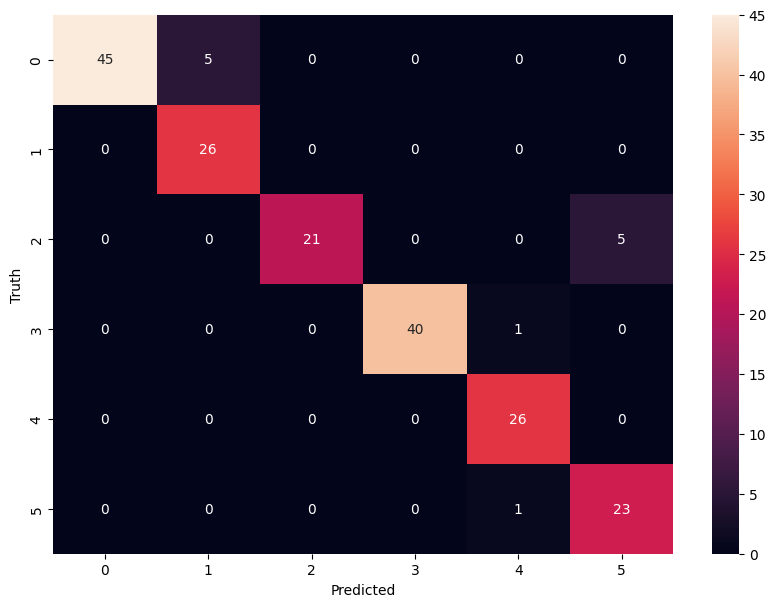

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def create_conf_matrix(model, test_dataloader, predictions):
    
    y_true =  [y for X, y in  test_dataloader]
    
    predictions = torch.stack(predictions)
    y_true = torch.cat(y_true)
    cm = confusion_matrix(y_true, predictions)

    return cm

cm = create_conf_matrix(best_model, test_loader, predictions)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [33]:
np.fill_diagonal(cm, 0)
new_m = cm.sum(axis = 1)
missclass_class = new_m.argmax()
print("Most missclassifed class:", missclass_class)

Most missclassifed class: 0


In [34]:
test_acc = metric_results["accuracy"]
test_rec = metric_results["recall"]
test_prec = metric_results["precision"]
test_f1 = metric_results["f1"]
#test_loss
for key,val in metric_results.items():
    print(f"{key}:",val.item())

accuracy: 0.9378238320350647
precision: 0.9314516186714172
recall: 0.9402725696563721
f1: 0.9314165115356445


Now we can save the model by using jit trace
The reason we use jit trace type of saving is so we can load the model
ready for use without the definition of the models class which is mandatory when using torch.save

## Model saving

In [35]:
#Traces the model through layers using random dummy data
traced_model = torch.jit.trace(model, torch.randn(1,51))
#Saves the model
torch.jit.save(traced_model, "model.pth")
